## MLFLOW для экспериментов с PyTorch

__Как запустить сервер:__

Команды терминала:

Включим нужное окружение conda:

>conda activate "название окружения conda"

Запустим сервер:

>mlflow server --backend-store-uri "папка на компьютере, где будут храниться результаты"

В конце можно добавить нужный порт (автоматом 5000) --host localhost --port 5000

пример:
>mlflow server --backend-store-uri "file:///D:/ML_flow_server/data_local" --host localhost --port 5000


По этой ссылке будет доступен MLflow:

http://localhost:5000



In [1]:
import torch
import mlflow
import numpy as np # библиотека работы с матрицами на цпу
import random
import torch.nn as nn # модуль библиотеки для создрания слоев 
import matplotlib.pyplot as plt # библиотека для отображения графиков и изображений
%matplotlib inline

In [2]:
# Установка Seed для воспроизводимости
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
import torchvision.transforms as transforms
import torchvision.utils
import torch.nn as nn


train_mnist = torchvision.datasets.MNIST('data_mnist/train', train=True, 
                                                transform=transforms.Compose([transforms.ToTensor()]),  
                                                download=True)
test_mnist = torchvision.datasets.MNIST('data_mnist/test', train=False, 
                                               transform=transforms.Compose([transforms.ToTensor()]), 
                                               download=True)

batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_mnist,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_mnist,
                batch_size=batch_size,
                shuffle=False)

__Создадаим fc сеть:__

In [28]:
class FCNetwork(nn.Module):
    def __init__(self, prob, n_inside):
        super(FCNetwork, self).__init__() 
        self.fc1 = nn.Linear(784, n_inside)
        self.fc2 = nn.Linear(n_inside, 10)
        self.fc1_act = nn.ReLU()
        self.dropout = nn.Dropout(p = prob)

    def forward(self,x):
        y = self.fc1(self.dropout(x))
        y = self.fc1_act(y)
        y = self.fc2(y)
        return y

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FCNetwork(prob=0.5, n_inside=100)
model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def accuracy(output, labels):
  predictions = torch.argmax(output, dim=1)
  correct = (predictions == labels).sum().cpu().numpy()
  return correct / len(labels)

Обучим сеть как обычно это делаем без трекинга в mlflow. Загружать будем локально на компьютер лучшую модель с мах test accuracy

In [30]:
maxacc = 0
for epoch in range(5):
    model.train()
    for itr, data in enumerate(train_loader):

        imgs = data[0].to(device) # [100,1,28,28] -> [B,H,W]
        labels = data[1].to(device)

        imgs = imgs.view(-1,28*28) # [100,28,28] -> [100,784] 
        y_pred = model(imgs) # [100,10]
        loss = loss_func(y_pred,labels)
        
        if itr % 200 == 0:
            print('Iteration {}, train accuracy {:.2f}, loss {:.4f}'.format(itr+epoch*len(train_loader),
                                                                            accuracy(y_pred,labels),loss))
        
        optimizer.zero_grad()
        loss.backward()   
        optimizer.step()

    model.eval()
    
    accuracies = []
    for itr,data in enumerate(test_loader):
        imgs = data[0].to(device)
        labels = data[1].to(device)
        imgs = imgs.view(-1,28*28)   
        y_pred = model(imgs)
        accuracies.append(accuracy(y_pred,labels))
    print(f'Test accuracy - {np.mean(np.array(accuracies))}')

    if np.mean(np.array(accuracies)) > maxacc:
        print('Saving model because its better')
        maxacc = np.mean(np.array(accuracies)) 
        torch.save(model,f'mymodel_fc.pth')


Iteration 0, train accuracy 0.08, loss 2.3224
Iteration 200, train accuracy 0.77, loss 1.3885
Iteration 400, train accuracy 0.75, loss 0.9633
Test accuracy - 0.8654999999999999
Saving model because its better
Iteration 600, train accuracy 0.87, loss 0.6897
Iteration 800, train accuracy 0.88, loss 0.5044
Iteration 1000, train accuracy 0.87, loss 0.5354
Test accuracy - 0.8941999999999999
Saving model because its better
Iteration 1200, train accuracy 0.84, loss 0.5770
Iteration 1400, train accuracy 0.86, loss 0.4731
Iteration 1600, train accuracy 0.89, loss 0.3857
Test accuracy - 0.9075
Saving model because its better
Iteration 1800, train accuracy 0.89, loss 0.3760
Iteration 2000, train accuracy 0.83, loss 0.5271
Iteration 2200, train accuracy 0.84, loss 0.5108
Test accuracy - 0.9122000000000001
Saving model because its better
Iteration 2400, train accuracy 0.84, loss 0.4455
Iteration 2600, train accuracy 0.87, loss 0.4448
Iteration 2800, train accuracy 0.87, loss 0.3888
Test accuracy - 

---

### Теперь воспользуемся MLFlow для трекинга экспериментов:

In [31]:
# Инициализация MLflow
#mlflow.set_tracking_uri("file:///D:/ML_flow_server/data_local")
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("PyTorch_test")

<Experiment: artifact_location='mlflow-artifacts:/464363596271834910', creation_time=1685117437457, experiment_id='464363596271834910', last_update_time=1685117437457, lifecycle_stage='active', name='PyTorch_test', tags={}>

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
prob = 0.2
n_inside = 250
lr = 1e-4
epochs = 7

In [33]:
with mlflow.start_run(run_name='FCNetwork_1') as run:

    model = FCNetwork(prob=prob, n_inside=n_inside)
    model.to(device)

    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    mlflow.log_param("prob dropout", prob)
    mlflow.log_param("neurons 2 layer", n_inside)
    mlflow.log_param("lr", lr)
    mlflow.log_param("optimizer", 'Adam')
    mlflow.log_param("epochs", epochs)

    maxacc = 0
    itr_record = 0
    for epoch in range(epochs):
        model.train()
        print(f'Началось обучение {epoch+1} эпохи')
        for itr, data in enumerate(train_loader):

            imgs = data[0].to(device) # [100,1,28,28] -> [B,H,W]
            labels = data[1].to(device)

            imgs = imgs.view(-1,28*28) # [100,28,28] -> [100,784] 
            y_pred = model(imgs) # [100,10]
            loss = loss_func(y_pred,labels)
            
            if itr % 200 == 0:
                mlflow.log_metric("accuracy_batch_train", accuracy(y_pred,labels), step=itr_record) 
                mlflow.log_metric("loss_batch_train", loss, step=itr_record) 
                itr_record += 1
                
            optimizer.zero_grad()
            loss.backward()   
            optimizer.step()

        model.eval()
        accuracies = []
        for itr,data in enumerate(test_loader):
            imgs = data[0].to(device)
            labels = data[1].to(device)
            imgs = imgs.view(-1,28*28)   
            y_pred = model(imgs)
            accuracies.append(accuracy(y_pred,labels))
        mlflow.log_metric("test_acc", np.mean(np.array(accuracies)), step=epoch) 

        if np.mean(np.array(accuracies)) > maxacc:
            # Saving model because its better
            mlflow.pytorch.log_model(model, "model")
            maxacc = np.mean(np.array(accuracies)) 
    print('max accuracy = ', maxacc)
mlflow.end_run()

Началось обучение 1 эпохи
Началось обучение 2 эпохи
Началось обучение 3 эпохи
Началось обучение 4 эпохи
Началось обучение 5 эпохи
Началось обучение 6 эпохи
Началось обучение 7 эпохи
max accuracy =  0.9427


___

### Использование __lightning__ для автологирования модели

In [34]:
import lightning.pytorch as pl

class FCNetwork_lightning(pl.LightningModule):
    def __init__(self, prob, n_inside):
        super(FCNetwork_lightning, self).__init__() 
        self.fc1 = nn.Linear(784, n_inside)
        self.fc2 = nn.Linear(n_inside, 10)
        self.fc1_act = nn.ReLU()
        self.dropout = nn.Dropout(p = prob)

    def forward(self,x):
        y = x.view(-1,28*28)
        y = self.fc1(self.dropout(y))
        y = self.fc1_act(y)
        y = self.fc2(y)
        return y

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.cross_entropy(y_hat, y)
        acc = accuracy(output=y_hat, labels=y)
        self.log("train_loss", loss, on_epoch=True)
        self.log("acc", acc, on_epoch=True)
        return loss
    
    def accuracy(output, labels):
        predictions = torch.argmax(output, dim=1)
        correct = (predictions == labels).sum().item()
        return correct / len(labels)
            
    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        true = (torch.argmax(y_hat, dim=1)==y).sum().item()
        acc = true/len(y)
        self.log("test_acc", acc, on_epoch=True)
        return acc

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

# Инициализация MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("PyTorch_test")
mlflow.pytorch.autolog()

prob = 0
n_inside = 50
model = FCNetwork_lightning(prob=prob, n_inside=n_inside)
trainer = pl.Trainer(max_epochs=5)

with mlflow.start_run(run_name='FCNetwork_lightning_2') as run:
    trainer.fit(model, train_loader)
    #trainer.test(dataloaders=test_loader)
    mlflow.log_param("prob dropout", prob)
    mlflow.log_param("neurons 2 layer", n_inside)

mlflow.end_run()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/05/26 21:22:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\Program files 2.0\Anaconda\lib\site-packages\mlflow\pytorch\_lightning_autolog.py:352: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.0.5 and 2.0.1.post0 and may not succeed with packages outside this range."
Missing logger folder: d:\YandexDisk\BMSTU\Программирование\Полезный контент для Data Science\MLOps\пример проекта с mlflow\lightning_logs

  | Name    | Type    | Params
------------------------------------
0 | fc1     | Linear  | 39.2 K
1 | fc2     | Linear  | 510   
2 | fc1_act | ReLU    | 0     
3 | dropout | Dropout | 0     
------------------------------------
39.8 K    Trainable params
0         Non-trainable params
39.8 K    Total params
0.159     Total estimated model params siz

Epoch 4: 100%|██████████| 600/600 [00:11<00:00, 51.36it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 600/600 [00:11<00:00, 50.89it/s, v_num=0]


### Запуск модели из mlflow

2023/05/26 21:16:09 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


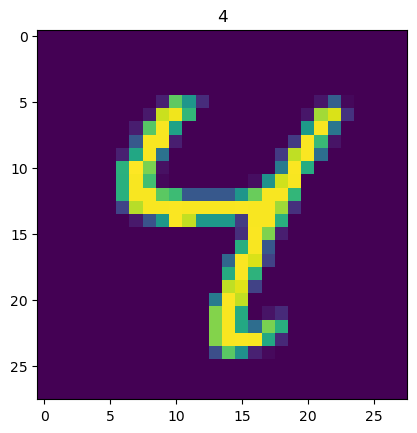

In [20]:
import mlflow
logged_model = 'runs:/b6acb72cbf3d4d03bc58539b9a518c3f/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

num = 6
y_pred = loaded_model.predict(test_mnist[num][0].numpy())  # Прогон через модель из MLflow
# принимает на вход np array

y_pred = torch.argmax(torch.tensor(y_pred), dim=1)
im = np.transpose(test_mnist[num][0].numpy(), (1, 2, 0))
plt.figure()
plt.imshow(im)  #w,h,c
plt.title(y_pred.numpy()[0])
plt.show()

In [21]:
count = 0
for i in range(len(test_mnist)):
    y_pred = loaded_model.predict(test_mnist[i][0].numpy()) 
    y_pred = torch.argmax(torch.tensor(y_pred), dim=1)
    if test_mnist[i][1] == y_pred:
        count += 1
print('test accuracy =', round(count/len(test_mnist), 4))


test accuracy = 0.9541


---

Обычная работа с моделью на компе в pytorch

In [13]:
model = FCNetwork(prob=0.5, n_inside=100)
wghts = torch.load('mymodel_fc.pth')
model.load_state_dict(wghts.state_dict())

#Переводит модель в режим инференса
model.eval()
device = 'cpu'
with torch.no_grad():
    accuracy_list = []
    for itr,data in enumerate(test_loader):
        imgs = data[0].to(device)
        labels = data[1].to(device)
        imgs = imgs.view(-1,28*28)
        y_pred = model.forward(imgs)
        accuracy_list.append(accuracy(y_pred,labels))

print('Test accuracy - {:.3f}'.format(np.sum(accuracy_list)/len(accuracy_list)))

Test accuracy - 0.916


## CONV сеть (классический подъод без mlflow):

In [7]:
class ConvNetwork(nn.Module):
    def __init__(self, n_inside):
        super(ConvNetwork, self).__init__() # 100,1,28,28
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=5, kernel_size=3, padding=1)   #100,5,28,28
        self.bn1 = nn.BatchNorm2d(5)
        self.act1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2) #100,5,14,14

        self.conv2 = torch.nn.Conv2d(
            in_channels=5, out_channels=10, kernel_size=3, padding=1)   #100,10,14,14
        self.bn2 = nn.BatchNorm2d(10)
        self.act2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2) #100,10,7,7

        self.conv3 = torch.nn.Conv2d(
            in_channels=10, out_channels=15, kernel_size=3, padding=1)   #100,15,7,7
        self.bn3 = nn.BatchNorm2d(15)
        self.act3 = torch.nn.ReLU()

        self.fc1 = nn.Linear(735, n_inside)
        self.fc1_act = nn.ReLU()
        self.fc2 = nn.Linear(n_inside, 10)


    def forward(self,x):
        y = self.pool1(self.act1(self.bn1(self.conv1(x))))
        y = self.pool2(self.act2(self.bn2(self.conv2(y))))
        y = self.act3(self.bn3(self.conv3(y)))
        y = y.view(-1, 15*7*7) 
        y = self.fc2(self.fc1_act(self.fc1(y)))
        return y

In [25]:
model = ConvNetwork(n_inside=50)
model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [26]:
maxacc = 0
for epoch in range(7):
    model.train()
    for itr, data in enumerate(train_loader):

        imgs = data[0].to(device) # [100,1,28,28] -> [B,H,W]
        labels = data[1].to(device)

        y_pred = model(imgs) # [100,10]
        loss = loss_func(y_pred,labels)
        
        if itr%200 == 0:
            print('Iteration {}, train accuracy {:.2f}, loss {:.4f}'.format(itr+epoch*len(train_loader),
                                                                            accuracy(y_pred,labels),loss))
        
        optimizer.zero_grad()
        loss.backward()   
        optimizer.step()

    model.eval()
    
    accuracies = []
    for itr,data in enumerate(test_loader):
        imgs = data[0].to(device)
        labels = data[1].to(device)
        y_pred = model(imgs)
        accuracies.append(accuracy(y_pred,labels))
    print(f'Test accuracy - {np.mean(np.array(accuracies))}')

    if np.mean(np.array(accuracies)) > maxacc:
        print('Saving model because its better')
        maxacc = np.mean(np.array(accuracies)) 
        torch.save(model,f'mymodel_conv.pth')

Iteration 0, train accuracy 0.13, loss 2.2760
Iteration 200, train accuracy 0.92, loss 0.6910
Iteration 400, train accuracy 0.95, loss 0.3954
Test accuracy - 0.9510999999999998
Saving model because its better
Iteration 600, train accuracy 0.96, loss 0.2044
Iteration 800, train accuracy 0.97, loss 0.1335
Iteration 1000, train accuracy 0.96, loss 0.1378
Test accuracy - 0.9679000000000001
Saving model because its better
Iteration 1200, train accuracy 0.98, loss 0.0953
Iteration 1400, train accuracy 0.98, loss 0.0814
Iteration 1600, train accuracy 0.98, loss 0.1281
Test accuracy - 0.9745999999999998
Saving model because its better
Iteration 1800, train accuracy 0.96, loss 0.1497
Iteration 2000, train accuracy 1.00, loss 0.0483
Iteration 2200, train accuracy 0.98, loss 0.1629
Test accuracy - 0.9783000000000002
Saving model because its better
Iteration 2400, train accuracy 0.99, loss 0.0733
Iteration 2600, train accuracy 0.98, loss 0.0541
Iteration 2800, train accuracy 0.97, loss 0.0570
Test

In [27]:
model = ConvNetwork(n_inside=50)
wghts = torch.load('mymodel_conv.pth')
model.load_state_dict(wghts.state_dict())

#Переводит модель в режим инференса
model.eval()
device = 'cpu'
with torch.no_grad():
    accuracy_list = []
    for itr,data in enumerate(test_loader):
        imgs = data[0].to(device)
        labels = data[1].to(device)
        y_pred = model.forward(imgs)
        accuracy_list.append(accuracy(y_pred,labels))

print('Test accuracy - {:.3f}'.format(np.sum(accuracy_list)/len(accuracy_list)))

Test accuracy - 0.983


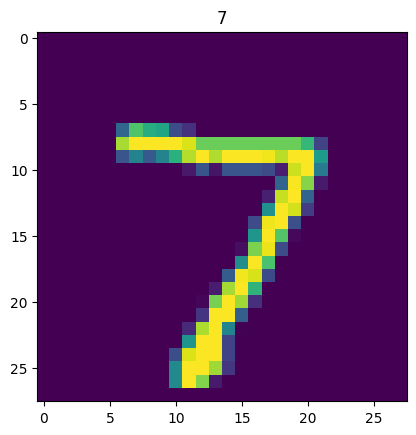

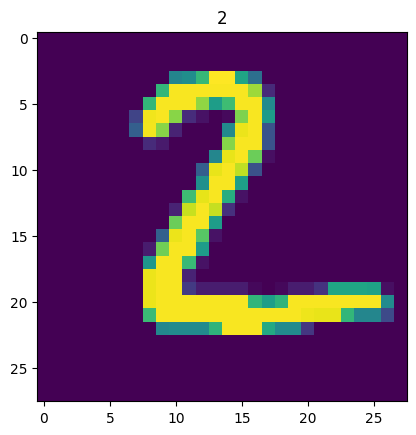

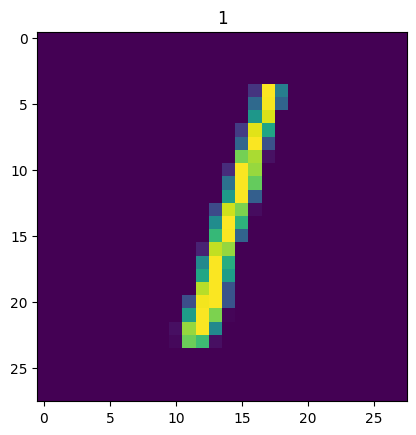

In [15]:
model.eval()
with torch.no_grad():
    for itr,data in enumerate(test_loader):
        if itr == 0:
            imgs = data[0].to(device)   #b,c,w,h
            labels = data[1].to(device)
            y_pred = model(imgs)
            y_pred = torch.argmax(y_pred, dim=1)
            for i in range(3):
                im = np.transpose((imgs[i].numpy()), (1, 2, 0))
                plt.figure()
                plt.imshow(im)  #w,h,c
                plt.title(y_pred[i].numpy())
                plt.show()